### Shape analysis

Calculate shape parameters and plot. Figures 3 and A1 in the paper.

In [8]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from mpl_toolkits.mplot3d import Axes3D

L = 480.279

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

First load the galaxy data at both $z=0$ and for high redshifts.

In [14]:
z0_gals = pd.read_csv('data/z0_virial_s9.csv', skiprows=59, skipfooter=1, engine='python')

In [4]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')
    

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97
6 8p22
7 8p93
8 9p72


We now define two functions. `norm_coods` sets the origin at the center of the protocluster being investigated (primarily to avoid periodic boundary effects). `calc_axes` calculates the eigenvalues and eigenvectors of the inertia tensor, and translates these in to the relative axis lengths.

In [ ]:
def norm_coods(coods, L):
    
    original_coods = coods.copy()
    
    for dim in range(3):
        
        if np.abs(coods[:,dim].max() - coods[:,dim].min()) > L/2:
            coods[:,dim] = coods[:,dim] - L
            coods[coods[:,dim] < -L/2,dim] = original_coods[coods[:,dim] < -L/2, dim]

    center = np.median(coods, axis=0)
    coods = coods - center
    
    return coods

In [5]:
def calc_axes(coods):
    """
    Args:
        coods - normed coordinates
        
    Returns:
        [a, b, c]:
        e_vectors:
    """
    
    I = np.zeros((3, 3))

    I[0,0] = np.sum(coods[:,1]**2 + coods[:,2]**2)
    I[1,1] = np.sum(coods[:,0]**2 + coods[:,2]**2)
    I[2,2] = np.sum(coods[:,1]**2 + coods[:,0]**2)

    I[0,1] = I[1,0] = - np.sum(coods[:,0] * coods[:,1])
    I[1,2] = I[2,1] = - np.sum(coods[:,2] * coods[:,1])
    I[0,2] = I[2,0] = - np.sum(coods[:,2] * coods[:,0])

    e_values, e_vectors = np.linalg.eig(I)
    
    sort_idx = np.argsort(e_values)
    
#     print e_values
#     print e_vectors
#     print sort_idx
    
    e_values = e_values[sort_idx]
    e_vectors = e_vectors[sort_idx,:]
    
#     print e_values
#     print e_vectors

    a = ((5. / (2 * len(coods))) * (e_values[1] + e_values[2] - e_values[0]))**0.5
    b = ((5. / (2 * len(coods))) * (e_values[0] + e_values[2] - e_values[1]))**0.5
    c = ((5. / (2 * len(coods))) * (e_values[0] + e_values[1] - e_values[2]))**0.5

#     print a, b, c
    
    return [a,b,c], e_vectors


To test, we plot the 3D galaxy distribution for three protoclusters at three different redshifts along with the three axis lengths orientated by their eigenvectors.

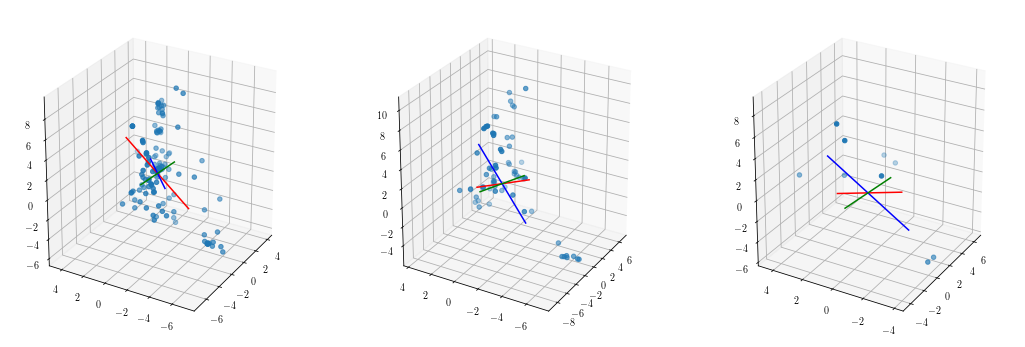

In [10]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

cols = ['r','b','g']

for gals_test, ax in zip([gals_mstar[0], gals_mstar[2], gals_mstar[4]], [ax1,ax2,ax3]):

    clusters = np.unique(gals_test[gals_test['z0_central_mcrit200'] > 1e4]['z0_centralId'])
    cluster = clusters[0]

    coods = np.array(gals_test[gals_test['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']])
    coods = norm_coods(coods, L)
    axes, e_vectors = calc_axes(coods)

    p = ax.scatter(coods[:,0], coods[:,1], zs=coods[:,2])

    for j in range(len(e_vectors)):        
        e_components = e_vectors[j] * axes[j]
        
#         print axes
        
        ax.plot([-e_components[0]/2., e_components[0]/2.], 
                [-e_components[1]/2., e_components[1]/2.], 
                [-e_components[2]/2., e_components[2]/2.], c=cols[j])

    ax.view_init(25, 210)

# plt.savefig('../papers/hightolowz/images/ax_3d.png', bbox_inches='tight', dpi=300)

#### $z=0$ axes

Now calculate the axis lengths for all clusters at $z=0$.

In [15]:
z0_axes = []

for i, cluster in enumerate(pd.unique(z0_gals['cen_haloId'])):
    coods = np.array(z0_gals[z0_gals['cen_haloId'] == cluster][['hen_x','hen_y','hen_z']])    
    coods = norm_coods(coods, L)
    ax, evec = calc_axes(coods)
    z0_axes.append(ax)
    
z0_axes = np.array(z0_axes)

#### $z = n$ axes

Define a function that calculates the axes lengths for all protoclusters given the galaxy dataframe. Apply to all galaxies.

In [21]:
def z_axes(gals):
    axes = []
    
    # print 'calculating axes...'

    for cluster in pd.unique(gals[gals['z0_central_mcrit200'] > 1e4]['z0_centralId']):
        
        if np.sum(gals['z0_centralId'] == cluster) < 20:
            # print "Not enough galaxies..."
            axes.append([np.nan, np.nan, np.nan])
            
        else:
            coods = np.array(gals[gals['z0_centralId'] == cluster][['zn_x','zn_y','zn_z']])
            coods = norm_coods(coods, L)
            ax, evec = calc_axes(coods)
            axes.append(ax)

    return np.array(axes)

In [22]:
zn_mstar10_axes = [z_axes(gals[gals['zn_stellarMass'] > 1]) for gals in gals_mstar]
zn_mstar_axes = [z_axes(gals) for gals in gals_mstar]
zn_sfr_axes = [z_axes(gals) for gals in gals_sfr]
zn_sfr5_axes = [z_axes(gals[gals['zn_sfr'] > 5]) for gals in gals_sfr]

In [24]:
# pcl.dump([zn_mstar_axes, zn_mstar10_axes, zn_sfr_axes, zn_sfr5_axes, z0_axes], open('data/axes_r200.p','wb'))
[zn_mstar_axes, zn_mstar10_axes, zn_sfr_axes, zn_sfr5_axes, z0_axes] = pcl.load(open('data/axes_r200.p', 'rb'))

### Plot distributions

We can now use the axes lengths to analyse the evolution of protocluster shape over time. In order to make best use of the axis lengths we calculate their ratios:

$$ s \equiv \frac{c}{a},\ \ \  q \equiv \frac{b}{a},\ \ \  p \equiv \frac{c}{b}$$

We also calculate the triaxiality parameter, a measure of prolateness / oblateness:

$$ T = \frac{a^{2} - b^{2}}{a^{2} - c^{2}} $$

Below we plot the 2D distributions of some of these parameters at a range of redshifts.

0 0 2.07
1 1 3.1
2 2 3.95
3 3 5.03
4 4 5.92
5 6 8.22


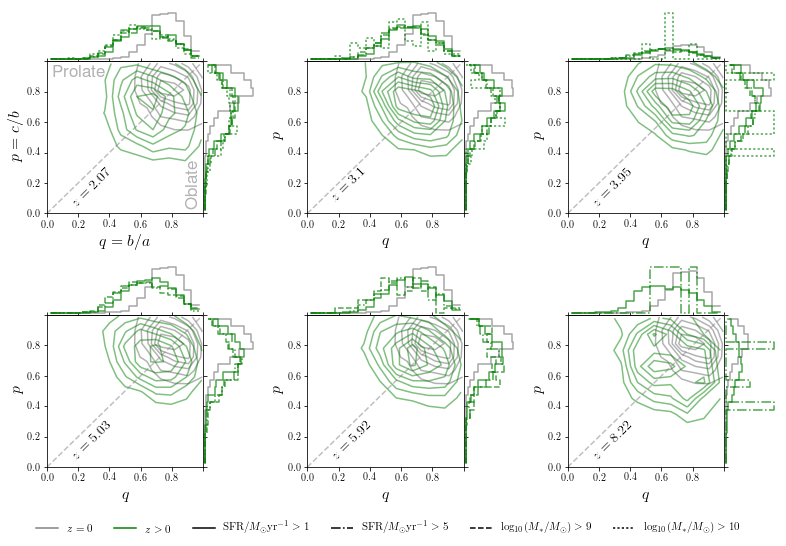

In [31]:
binLimits = np.linspace(0, 1, 21)
bins = np.linspace(0.025, 0.975, 20)

ls = ['solid','dashdot','dashed','dotted']

fig = plt.figure(figsize=(14,14))

gs = gridspec.GridSpec(15, 15)

gs.update(wspace=0, hspace=0) #, wspace=0) bottom = 0.57, top = 1,

ax1 = [fig.add_subplot(gs[1:4, 0:3]), fig.add_subplot(gs[0, 0:3]), fig.add_subplot(gs[1:4, 3])]
ax2 = [fig.add_subplot(gs[1:4, 5:8]), fig.add_subplot(gs[0, 5:8]), fig.add_subplot(gs[1:4, 8])]
ax3 = [fig.add_subplot(gs[1:4, 10:13]), fig.add_subplot(gs[0, 10:13]), fig.add_subplot(gs[1:4, 13])]

ax4 = [fig.add_subplot(gs[6:9, 0:3]), fig.add_subplot(gs[5, 0:3]), fig.add_subplot(gs[6:9, 3])]
ax5 = [fig.add_subplot(gs[6:9, 5:8]), fig.add_subplot(gs[5, 5:8]), fig.add_subplot(gs[6:9, 8])]
ax6 = [fig.add_subplot(gs[6:9, 10:13]), fig.add_subplot(gs[5, 10:13]), fig.add_subplot(gs[6:9, 13])]

idxs = [0, 1, 2, 3, 4, 6]

for i, (idx, z, ax) in enumerate(zip(idxs, np.array(zees)[idxs], [ax1,ax2,ax3,ax4,ax5,ax6])):
    
    print i, idx, z
    
    # z = 0
    counts, xbins, ybins = np.histogram2d(z0_axes[:,1] / z0_axes[:,0],
                                          z0_axes[:,2] / z0_axes[:,1],
                                          bins=8)

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], 
                colors='grey', alpha=0.6)
    
    # z = n    
    counts, xbins, ybins = np.histogram2d(
                                zn_sfr_axes[idx][np.where(np.isfinite(zn_sfr_axes[idx][:,0])),1][0] / \
                                zn_sfr_axes[idx][np.where(np.isfinite(zn_sfr_axes[idx][:,0])),0][0],
                                zn_sfr_axes[idx][np.where(np.isfinite(zn_sfr_axes[idx][:,0])),2][0] / \
                                zn_sfr_axes[idx][np.where(np.isfinite(zn_sfr_axes[idx][:,0])),1][0],
                                bins=8)

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                alpha=0.5, label=str(z), colors='green')
    
    
    phi, dummy = np.histogram(z0_axes[:,1] / z0_axes[:,0],
                                  bins=binLimits, normed=True)

    ax[1].step(bins, phi, c='grey', alpha=0.7)
    
    phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,1],
                                  bins=binLimits, normed=True)

    ax[2].step(phi, bins, c='grey', alpha=0.7)
    
    for j, axes in enumerate([zn_sfr_axes[idx], zn_sfr5_axes[idx], zn_mstar_axes[idx], zn_mstar10_axes[idx]]):
        # top marginal
        phi, dummy = np.histogram(axes[np.where(np.isfinite(axes[:,0])),1] / \
                                  axes[np.where(np.isfinite(axes[:,0])),0],
                                  bins=binLimits, normed=True)

        ax[1].step(bins, phi, c='green', linestyle=ls[j], alpha=0.7)

        # right marginal
        phi, dummy = np.histogram(axes[np.where(np.isfinite(axes[:,0])),2] / \
                                  axes[np.where(np.isfinite(axes[:,0])),1],
                                  bins=binLimits, normed=True)

        ax[2].step(phi, bins, c='green', linestyle=ls[j], alpha=0.7)

        

        
    ax[0].plot([0,1],[0,1], linestyle='dashed', c='grey', alpha=0.5)
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    #ax.grid()
    
    ax[0].set_xlabel('$q$', size=16)
    ax[0].set_ylabel('$p$', size=16)
    
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    
    ax[1].get_xaxis().set_tick_params(direction='in')
    ax[2].get_yaxis().set_tick_params(direction='in')
    
    ax[1].set_xlim(0,1)
    ax[2].set_ylim(0,1)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    
    ax[0].text(0.14, .25, '$z = %s$'%z, rotation=45, size=14)#, color='grey')
    
    ax[0].set_xticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])
    ax[0].set_yticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])


ax1[0].text(0.88, 0.27, 'Oblate', rotation=90, size=17, alpha=0.3)
ax1[0].text(0.04, 0.9, 'Prolate', size=17, alpha=0.3)

ax1[0].set_xlabel('$q = b/a$', size=16)
ax1[0].set_ylabel('$p = c/b$', size=16)

z0Artist = plt.Line2D((0,1),(0,0), color='grey')
zNArtist = plt.Line2D((0,1),(0,0), color='green')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
sfrArtist5 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashdot')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax6[2].legend(handles=[z0Artist, zNArtist, sfrArtist, sfrArtist5, mstar9Artist, mstar10Artist],
           labels=['$z = 0$','$z > 0$','$\mathrm{SFR} / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{SFR} / M_{\odot} \mathrm{yr}^{-1} > 5$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(0.5, -0.3), prop={'size':11}, frameon=False, ncol=6)
  
# plt.savefig(out_directory+'pq_2d.png', bbox_inches='tight', dpi=300)

Triaxiality parameter distribution:

z: 2.07 T: 0.672458474332 0.196956595046
z: 3.1 T: 0.6699127192 0.197681963625
z: 3.95 T: 0.668694524329 0.199399434933
z: 5.03 T: 0.672974064869 0.194667354633
z: 5.92 T: 0.670222767544 0.198794067955
z: 8.22 T: 0.690476395404 0.198288839969


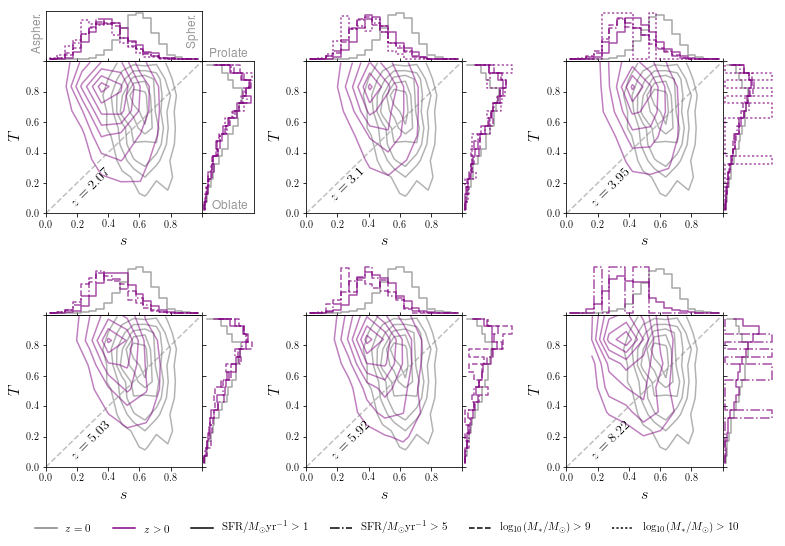

In [35]:
fig = plt.figure(figsize=(14,14))

gs = gridspec.GridSpec(15, 15)

gs.update(wspace=0, hspace=0) #, wspace=0) bottom = 0.57, top = 1,

ax1 = [fig.add_subplot(gs[1:4, 0:3]), fig.add_subplot(gs[0, 0:3]), fig.add_subplot(gs[1:4, 3])]
ax2 = [fig.add_subplot(gs[1:4, 5:8]), fig.add_subplot(gs[0, 5:8]), fig.add_subplot(gs[1:4, 8])]
ax3 = [fig.add_subplot(gs[1:4, 10:13]), fig.add_subplot(gs[0, 10:13]), fig.add_subplot(gs[1:4, 13])]

ax4 = [fig.add_subplot(gs[6:9, 0:3]), fig.add_subplot(gs[5, 0:3]), fig.add_subplot(gs[6:9, 3])]
ax5 = [fig.add_subplot(gs[6:9, 5:8]), fig.add_subplot(gs[5, 5:8]), fig.add_subplot(gs[6:9, 8])]
ax6 = [fig.add_subplot(gs[6:9, 10:13]), fig.add_subplot(gs[5, 10:13]), fig.add_subplot(gs[6:9, 13])]

idxs = [0, 1, 2, 3, 4, 6]

for i, (idx, z, ax) in enumerate(zip(idxs, np.array(zees)[idxs], [ax1,ax2,ax3,ax4,ax5,ax6])):
    
    # z = 0
    T = (z0_axes[:,0]**2 - z0_axes[:,1]**2) / \
        (z0_axes[:,0]**2 - z0_axes[:,2]**2)
        
#     print "T:", np.mean(T), np.std(T)
        
    counts, xbins, ybins = np.histogram2d(z0_axes[:,2] / z0_axes[:,0], T, bins=10)
    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], 
            colors='grey', alpha=0.6)
    
    phi, dummy = np.histogram(T, bins=binLimits, normed=True)
    ax[2].step(phi, bins, c='grey', alpha=0.7)
    
    phi, dummy = np.histogram(z0_axes[:,2] / z0_axes[:,0], bins=binLimits, normed=True)
    ax[1].step(bins, phi, c='grey', alpha=0.7)
    
    # z = n
    axes = zn_sfr_axes[idx]
    
    T = (axes[np.where(np.isfinite(axes[:,0])),0]**2 - axes[np.where(np.isfinite(axes[:,0])),1]**2) / \
        (axes[np.where(np.isfinite(axes[:,0])),0]**2 - axes[np.where(np.isfinite(axes[:,0])),2]**2)
        
    print "z:", z, "T:", np.mean(T), np.std(T)
    
    counts, xbins, ybins = np.histogram2d(axes[np.where(np.isfinite(axes[:,0])),2][0] / 
                                          axes[np.where(np.isfinite(axes[:,0])),0][0], T[0], bins=7)

    ax[0].contour(counts.transpose(), extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                  colors='purple', alpha=0.5, label=str(z))    
    
    for j, axes in enumerate([zn_sfr_axes[idx], zn_sfr5_axes[idx], zn_mstar_axes[idx], zn_mstar10_axes[idx]]):
        
        T = (axes[np.where(np.isfinite(axes[:,0])),0]**2 - axes[np.where(np.isfinite(axes[:,0])),1]**2) / \
            (axes[np.where(np.isfinite(axes[:,0])),0]**2 - axes[np.where(np.isfinite(axes[:,0])),2]**2)

        # top marginal
        phi, dummy = np.histogram(axes[np.where(np.isfinite(axes[:,0])),2] / \
                                  axes[np.where(np.isfinite(axes[:,0])),0],
                                  bins=binLimits, normed=True)

        ax[1].step(bins, phi, c='purple', linestyle=ls[j], alpha=0.7)

        # right marginal
        phi, dummy = np.histogram(T, bins=binLimits, normed=True)

        ax[2].step(phi, bins, c='purple', linestyle=ls[j], alpha=0.7)
    
    
        
    ax[0].plot([0,1],[0,1], linestyle='dashed', c='grey', alpha=0.5)
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,1)
    #ax.grid()
    
    ax[0].set_xlabel('$s$', size=16)
    ax[0].set_ylabel('$T$', size=16)
    
    ax[1].set_yticks([])
    ax[2].set_xticks([])
    
    ax[1].set_xticklabels([])
    ax[2].set_yticklabels([])
    
    ax[1].get_xaxis().set_tick_params(direction='in')
    ax[2].get_yaxis().set_tick_params(direction='in')
    
    ax[1].set_xlim(0,1)
    ax[2].set_ylim(0,1)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['bottom'].set_visible(False)
    
    ax[0].text(0.14, .25, '$z = %s$'%z, rotation=45, size=14)#, color='grey')
    
    ax[0].set_xticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])
    ax[0].set_yticklabels(['$0.0$','$0.2$','$0.4$','$0.6$','$0.8$',''])



ax1[1].spines['top'].set_visible(True)
ax1[1].spines['right'].set_visible(True)
ax1[1].spines['left'].set_visible(True)

ax1[2].spines['top'].set_visible(True)
ax1[2].spines['right'].set_visible(True)
ax1[2].spines['bottom'].set_visible(True)

ax1[2].text(0.38, 0.03, 'Oblate', size=12, alpha=0.4)
ax1[2].text(0.3, 1.03, 'Prolate', size=12, alpha=0.4)

ax1[1].text(0.9, 3, 'Spher.', rotation=90, size=12, alpha=0.4)
ax1[1].text(-0.09, 3.1, 'Aspher.', rotation=90, size=12, alpha=0.4)

# legend

z0Artist = plt.Line2D((0,1),(0,0), color='grey')
zNArtist = plt.Line2D((0,1),(0,0), color='purple')

sfrArtist = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
sfrArtist5 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashdot')
mstar9Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
mstar10Artist = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

ax6[2].legend(handles=[z0Artist, zNArtist, sfrArtist, sfrArtist5, mstar9Artist, mstar10Artist],
           labels=['$z = 0$','$z > 0$','$\mathrm{SFR} / M_{\odot} \mathrm{yr}^{-1} > 1$',
                   '$\mathrm{SFR} / M_{\odot} \mathrm{yr}^{-1} > 5$',
                   '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 9$',
                  '$\mathrm{log_{10}}(M_{*} / M_{\odot}) > 10$'], 
           bbox_to_anchor=(0.5, -0.3), prop={'size':11}, frameon=False, ncol=6)

    
# plt.savefig(out_directory+'sT_2d.png', bbox_inches='tight', dpi=300)